In [1]:
import datetime
import os
import copy
import sys
import csv
import random
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from tqdm import tqdm
import pickle
from statistics import mean
from scipy.stats import pearsonr # 科学技術計算ライブラリ
from PIL import Image
import statistics

/home/taki/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir = '/home/taki/bento_conditional/log/BEST_conditional_0_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
out_df_list   = []
score_df_list = []


col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

for cv_num in range(5):
    out_dir   = f"/closs_valid{cv_num}/test_out_df.csv"
    score_dir = f"/closs_valid{cv_num}/test_score_df.csv"
    out_dir   = dir + out_dir
    score_dir = dir + score_dir

    out_df = pd.read_csv(out_dir)
    score_df = pd.read_csv(score_dir)

    out_df_list.append(out_df)
    score_df_list.append(score_df)

out_df = out_df_list[0]
score_df = score_df_list[0]
for i in range(len(out_df_list)-1):
    out_df = pd.concat([out_df,out_df_list[i+1]])
    score_df = pd.concat([score_df,score_df_list[i+1]])

out_df = out_df.drop("Unnamed: 0",axis=1)
score_df = score_df.drop("Unnamed: 0",axis=1)

col_list = {}
for i in range(len(col)):
    col_list[f"{i}"] = col[i]
out_df = out_df.rename(columns=col_list)
out_df = out_df.reset_index(drop=True)
score_df = score_df.rename(columns=col_list)
score_df = score_df.reset_index(drop=True)


In [3]:
for i in out_df_list:
    print(len(i))

200
200
199
199
199


## 交差検証のデータごとに相関係数だす

In [4]:
for i in range(0,5):
    out_df_list[i] = out_df_list[i].drop("Unnamed: 0",axis=1)
    score_df_list[i] = score_df_list[i].drop("Unnamed: 0",axis=1)
    out_df_list[i] = out_df_list[i].rename(columns=col_list)
    out_df_list[i] = out_df_list[i].reset_index(drop=True)
    score_df_list[i] = score_df_list[i].rename(columns=col_list)
    score_df_list[i] = score_df_list[i].reset_index(drop=True)

In [5]:
corr_list = []
p_list = []
mae_df_list = []
for idx in range(0,5):
    #print(f"~~~~~~~~~~K={idx}~~~~~~~~~~~~~~~~~~~")
    corr_tmp = []
    p_tmp = []
    mae_df_list.append(abs(out_df_list[idx]-score_df_list[idx]))
    for i in range(len(col)):
        
        
        #print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
        a, b = pearsonr(score_df_list[idx][col[i]], out_df_list[idx][col[i]]) # リストを整形し相関係数:aとp値:bの計算
        #print("相関係数:", a)
        #print("p値:", b)
        corr_tmp.append(a)
        p_tmp.append(b)
    corr_list.append(corr_tmp)
    p_list.append(p_tmp)

In [26]:
corr_df = pd.DataFrame(corr_list)
corr_df

0         1         2         3         4         5         6
0  0.642120  0.449436  0.523397  0.556643  0.522582  0.191008  0.197570
1  0.621511  0.401900  0.491482  0.520817  0.521009  0.175117  0.269737
2  0.665767  0.548692  0.483554  0.606350  0.542358  0.338166  0.291834
3  0.622917  0.406769  0.503969  0.556805  0.474416  0.244319  0.295839
4  0.597558  0.447740  0.539034  0.459032  0.510317  0.267118  0.379990

In [27]:
for i in range(7):
    print(f"{col[i]}:{corr_df.mean()[i].round(5)}±{corr_df.std()[i].round(5)}")

color:0.62997±0.0255
healthy:0.45091±0.059
satisfaction:0.50829±0.02284
uniqueness:0.53993±0.05451
ease of eating:0.51414±0.02504
appropriate amount:0.24315±0.0651
not collapse:0.28699±0.06528


In [6]:
score_df

color   healthy  satisfaction  uniqueness  ease of eating  \
0    0.471011  0.704399      0.663426    0.224478        0.344031   
1    0.653869  0.774155      0.706534    0.403172        0.325253   
2    0.962118  0.326577      0.420994    0.223660        0.510186   
3    0.579813  0.474504      0.641254    0.677865        0.397036   
4    0.724853  0.374028      0.606000    0.119498        0.429201   
..        ...       ...           ...         ...             ...   
992  0.655700  0.414419      0.725615    0.363594        0.269500   
993  0.741438  0.400103      0.501803    0.265165        0.623965   
994  0.345177  0.708374      0.558813    0.797181        0.391029   
995  0.616899  0.632339      0.628088    0.308381        0.444197   
996  0.954538  0.418144      0.483255    0.167986        0.357655   

     appropriate amount  not collapse  
0              0.396553      0.467711  
1              0.470504      0.578461  
2              0.406695      0.180624  
3              0.642581      0.475547  
4              0.253319      0.489199  
..                  ...           ...  
992            0.523082      0.230509  
993            0.154166      0.414959  
994            0.591896      0.279568  
995            0.481864      0.634117  
996            0.213014      0.703562  

[997 rows x 7 columns]

In [7]:
mae_df = pd.concat([mae_df_list[0],mae_df_list[1]])
for i in range(2,5):
    mae_df = pd.concat([mae_df,mae_df_list[i]])
mae_df = mae_df.reset_index(drop=True)
mae_df

color   healthy  satisfaction  uniqueness  ease of eating  \
0    0.209528  0.081050      0.024903    0.247111        0.189749   
1    0.009930  0.293930      0.108646    0.256710        0.052736   
2    0.272062  0.259861      0.225581    0.062599        0.168062   
3    0.227363  0.158508      0.039401    0.098060        0.044161   
4    0.131828  0.134868      0.113648    0.154608        0.105264   
..        ...       ...           ...         ...             ...   
992  0.151569  0.009693      0.076313    0.173923        0.164672   
993  0.260314  0.124415      0.164033    0.174849        0.135638   
994  0.011843  0.127029      0.004010    0.163052        0.066259   
995  0.075157  0.132430      0.032373    0.138700        0.046410   
996  0.294005  0.037507      0.218075    0.326292        0.005382   

     appropriate amount  not collapse  
0              0.005801      0.000596  
1              0.012691      0.099825  
2              0.001645      0.310968  
3              0.138334      0.050901  
4              0.195742      0.051798  
..                  ...           ...  
992            0.021713      0.188108  
993            0.296096      0.026783  
994            0.039473      0.158034  
995            0.054094      0.237178  
996            0.298806      0.231652  

[997 rows x 7 columns]

In [8]:
for i in range(len(col)):
    print("MAE:",mae_df[col[i]].mean(),"±",mae_df[col[i]].std())

MAE: 0.10013867768906722 ± 0.07763195504280451
MAE: 0.10405495030692077 ± 0.07889547541223976
MAE: 0.08504015865596791 ± 0.07075479543679453
MAE: 0.10672083304012037 ± 0.08511353247638241
MAE: 0.0753803814122367 ± 0.06417311184041713
MAE: 0.0937917450110331 ± 0.07952022228572506
MAE: 0.10520063996890672 ± 0.08093645780287663


In [9]:
for i in range(len(col)):
    print(f"{col[i]}_min:",mae_df[col[i]].min(),",",f"{col[i]}_max:",mae_df[col[i]].max())

color_min: 0.00012626000000004467 , color_max: 0.60406137
healthy_min: 1.819999999996824e-05 , healthy_max: 0.5338052
satisfaction_min: 5.295999999999079e-05 , satisfaction_max: 0.524227
uniqueness_min: 0.0003746500000000319 , uniqueness_max: 0.52958244
ease of eating_min: 3.96000000000285e-05 , ease of eating_max: 0.51072758
appropriate amount_min: 7.756999999997127e-05 , appropriate amount_max: 0.5805319800000001
not collapse_min: 0.00020916999999998076 , not collapse_max: 0.42000873


findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


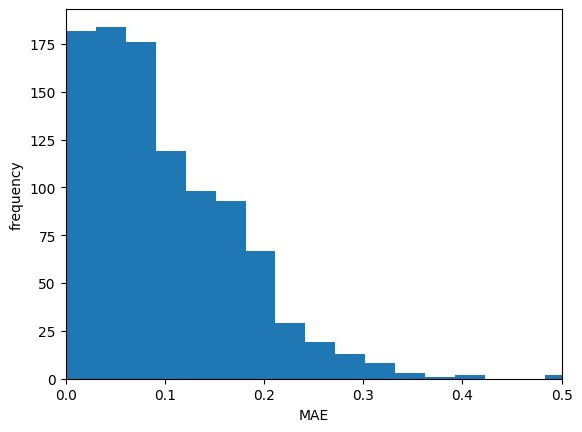

color_min: 0.00012626000000004467 , color_max: 0.60406137


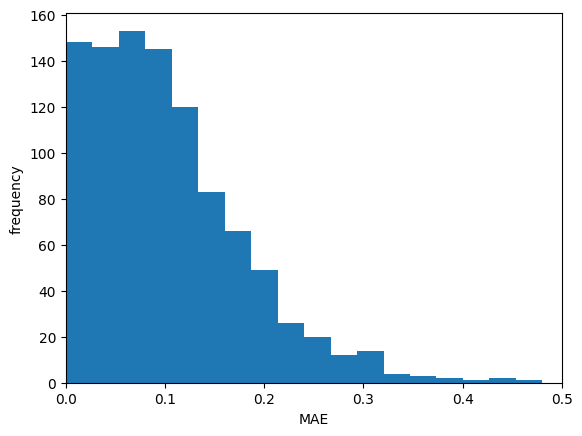

healthy_min: 1.819999999996824e-05 , healthy_max: 0.5338052


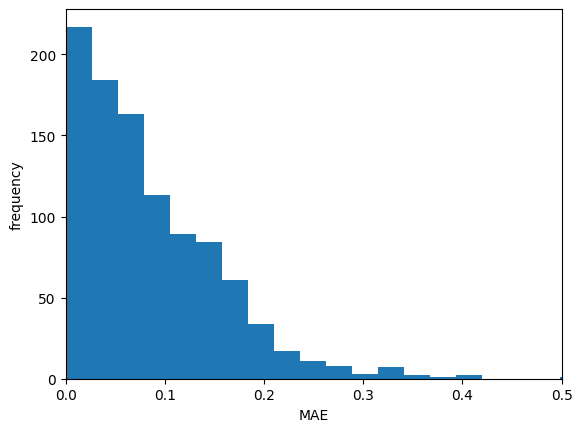

satisfaction_min: 5.295999999999079e-05 , satisfaction_max: 0.524227


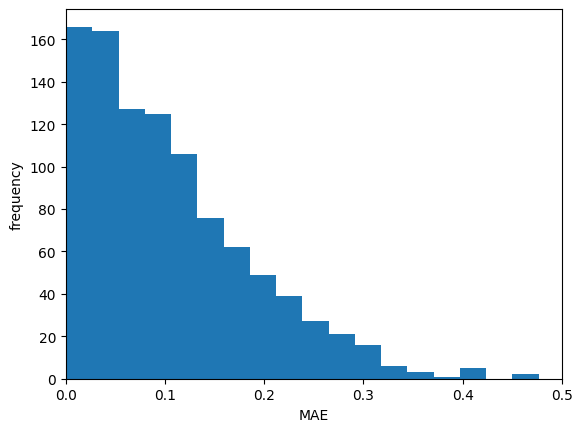

uniqueness_min: 0.0003746500000000319 , uniqueness_max: 0.52958244


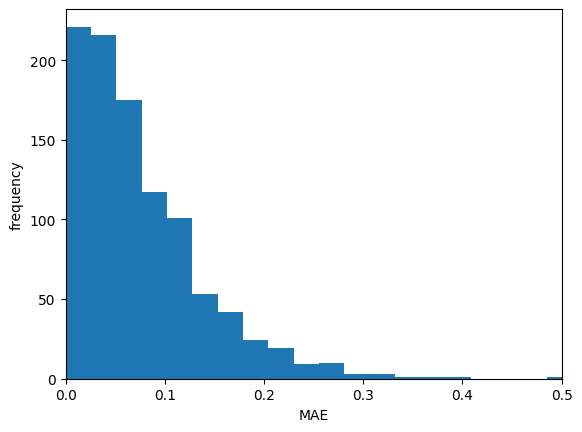

ease of eating_min: 3.96000000000285e-05 , ease of eating_max: 0.51072758


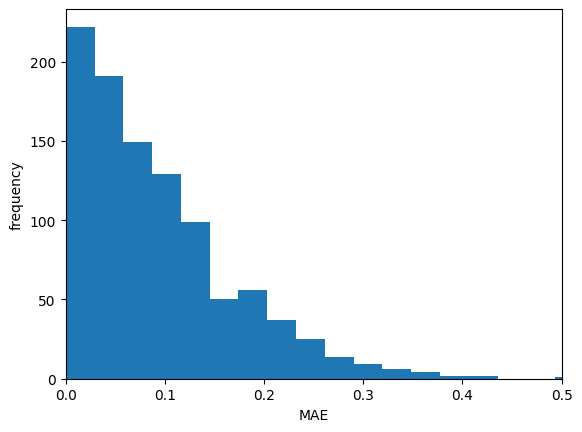

appropriate amount_min: 7.756999999997127e-05 , appropriate amount_max: 0.5805319800000001


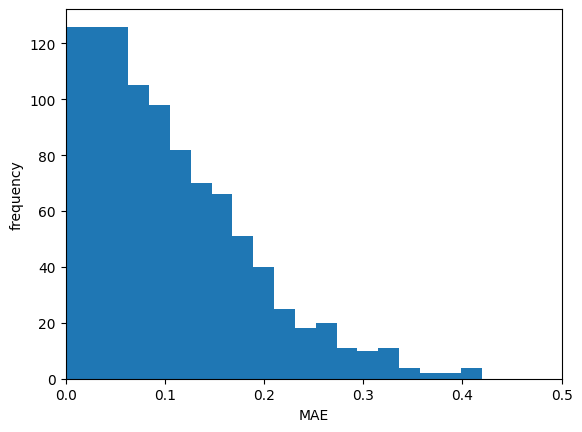

not collapse_min: 0.00020916999999998076 , not collapse_max: 0.42000873


In [10]:
for i in range(len(col)):
    #plt.title(col[i])
    plt.xlabel("MAE")
    plt.ylabel("frequency")
    plt.hist(mae_df[col[i]],bins=20)
    plt.xlim(0,0.5)
    #plt.ylim(0,120)
    
    img_path = f"./MAE_{col[i]}.png"
    #plt.savefig(img_path)#, transparent=True)
    plt.show()
    print(f"{col[i]}_min:",mae_df[col[i]].min(),",",f"{col[i]}_max:",mae_df[col[i]].max())

In [11]:
score_df[180:201]

color   healthy  satisfaction  uniqueness  ease of eating  \
180  0.370226  0.256407      0.375962    0.595607        0.671754   
181  0.177662  0.892860      0.759829    0.551196        0.302575   
182  0.610938  0.472144      0.742358    0.140055        0.645357   
183  0.710697  0.487513      0.436175    0.352022        0.512248   
184  0.679446  0.513337      0.620472    0.438047        0.511334   
185  0.611302  0.690660      0.620428    0.306028        0.485455   
186  0.564014  0.596671      0.544699    0.467072        0.618879   
187  0.556827  0.612603      0.601841    0.395095        0.495287   
188  0.762327  0.581813      0.638487    0.348858        0.434208   
189  0.659597  0.451752      0.487970    0.352070        0.564499   
190  0.742105  0.453447      0.507075    0.250246        0.522577   
191  0.398442  0.481424      0.747307    0.833754        0.487029   
192  0.656941  0.247645      0.662987    0.550613        0.605428   
193  0.476351  0.538782      0.442980    0.291077        0.576909   
194  0.193843  0.756107      0.717993    0.567806        0.478914   
195  0.518102  0.551295      0.607948    0.516094        0.591742   
196  0.490030  0.402881      0.644883    0.743846        0.235256   
197  0.687667  0.448039      0.582646    0.568542        0.379040   
198  0.690054  0.670745      0.624765    0.455195        0.489161   
199  0.643530  0.609545      0.571979    0.316272        0.467512   
200  0.642424  0.400722      0.459411    0.664658        0.615425   

     appropriate amount  not collapse  
180            0.389391      0.334762  
181            0.460792      0.273929  
182            0.237687      0.566476  
183            0.233719      0.499170  
184            0.516780      0.510864  
185            0.352984      0.665867  
186            0.374081      0.521566  
187            0.454591      0.566527  
188            0.489834      0.617814  
189            0.261570      0.439725  
190            0.377534      0.604510  
191            0.752602      0.330089  
192            0.584068      0.142479  
193            0.235043      0.520757  
194            0.596305      0.605698  
195            0.464261      0.390273  
196            0.771772      0.481189  
197            0.405153      0.420590  
198            0.334061      0.724693  
199            0.455004      0.500178  
200            0.358513      0.344846

## maeが上位5枚下位５枚を出力する

In [12]:
img_mae_list = []
all_mae_list = []
sum_mae_list = []

for idx in range(5):
    print(idx)
    img_mae_list = []

    for i in range(len(mae_df_list[idx])):
        img_mae_list.append(mae_df_list[idx].loc[i].mean())
        all_mae_list.append(mae_df_list[idx].loc[i].mean())
        sum_mae_list.append(mae_df_list[idx].loc[i].sum())
    print(np.mean(img_mae_list),"±",np.std(img_mae_list))

0
0.09852066170285713 ± 0.04369464263593074
1
0.09332585882857142 ± 0.0376663429645413
2
0.09119329371931086 ± 0.03825944526363268
3
0.09941742098994975 ± 0.041652572265026805
4
0.09634641033165829 ± 0.039353766835602176


In [13]:
sum_mae_list


[0.7587393699999999,
 0.83446865,
 1.30077817,
 0.7567287699999999,
 0.88775563,
 0.6492889100000002,
 0.78967257,
 0.5086336300000002,
 0.5338158100000001,
 0.7107993400000002,
 0.7568278399999999,
 0.5716751099999999,
 0.5784020700000001,
 1.3045573959999999,
 0.8135084799999999,
 0.39623223000000013,
 0.89164263,
 0.4584802099999998,
 0.70179609,
 0.8977986600000001,
 0.39252875,
 0.2980517899999999,
 0.29792019,
 0.56286839,
 1.2543277099999999,
 0.4459227599999999,
 0.7827347400000002,
 0.64622769,
 0.5808844500000001,
 0.7671239999999999,
 1.0358283700000002,
 0.6359406999999998,
 0.4138302999999999,
 0.47946414,
 0.69510093,
 0.46243367,
 0.30246502000000003,
 0.5678062300000001,
 0.3821179800000001,
 0.3860001800000002,
 0.99972547,
 0.6418598499999999,
 0.41043604000000006,
 0.44177602999999993,
 0.65219359,
 0.45683779,
 0.4999789600000001,
 0.4011480000000001,
 0.9727010999999999,
 1.62792584,
 0.45509098999999986,
 0.6352736200000001,
 0.60383158,
 0.30249441999999993,
 0.6

In [14]:
mae_df["img_mae"] = all_mae_list
mae_df = mae_df.reset_index(drop=True)
mae_df["sum_mae"] = sum_mae_list
mae_df = mae_df.reset_index(drop=True)
mae_df

color   healthy  satisfaction  uniqueness  ease of eating  \
0    0.209528  0.081050      0.024903    0.247111        0.189749   
1    0.009930  0.293930      0.108646    0.256710        0.052736   
2    0.272062  0.259861      0.225581    0.062599        0.168062   
3    0.227363  0.158508      0.039401    0.098060        0.044161   
4    0.131828  0.134868      0.113648    0.154608        0.105264   
..        ...       ...           ...         ...             ...   
992  0.151569  0.009693      0.076313    0.173923        0.164672   
993  0.260314  0.124415      0.164033    0.174849        0.135638   
994  0.011843  0.127029      0.004010    0.163052        0.066259   
995  0.075157  0.132430      0.032373    0.138700        0.046410   
996  0.294005  0.037507      0.218075    0.326292        0.005382   

     appropriate amount  not collapse   img_mae   sum_mae  
0              0.005801      0.000596  0.108391  0.758739  
1              0.012691      0.099825  0.119210  0.834469  
2              0.001645      0.310968  0.185825  1.300778  
3              0.138334      0.050901  0.108104  0.756729  
4              0.195742      0.051798  0.126822  0.887756  
..                  ...           ...       ...       ...  
992            0.021713      0.188108  0.112284  0.785991  
993            0.296096      0.026783  0.168876  1.182129  
994            0.039473      0.158034  0.081386  0.569701  
995            0.054094      0.237178  0.102335  0.716342  
996            0.298806      0.231652  0.201674  1.411719  

[997 rows x 9 columns]

In [15]:
img_mae_list = []

for idx in range(5):
    print(idx)
    for i in range(len(mae_df_list[idx])):
        img_mae_list.append(mae_df_list[idx].loc[i].mean())
    print(np.mean(img_mae_list),"±",np.std(img_mae_list))

0
0.09852066170285713 ± 0.04369464263593074
1
0.09592326026571428 ± 0.04087461422359537
2
0.0943518690424517 ± 0.040086715928435754
3
0.0956150831245972 ± 0.04054214795466027
4
0.09576105515489325 ± 0.04030880722538785


### 各交差検証でのMAE

In [16]:
dic0 = {}


for idx in range(len(mae_df_list)):
    print(f"###################{idx}#################")
    tmp_dic = {}
    for i in range(len(col)):
        #tmp_str = str(mae_df_list[idx][col[i]].mean()),"±",mae_df_list[idx][col[i]].std()
        print(col[i],":",round(mae_df_list[idx][col[i]].mean(),4),"±",round(mae_df_list[idx][col[i]].std(),4))

###################0#################
color : 0.1054 ± 0.0805
healthy : 0.1081 ± 0.0834
satisfaction : 0.0838 ± 0.0757
uniqueness : 0.1143 ± 0.0982
ease of eating : 0.0701 ± 0.0619
appropriate amount : 0.0997 ± 0.0853
not collapse : 0.1084 ± 0.0826
###################1#################
color : 0.0957 ± 0.0747
healthy : 0.1025 ± 0.0788
satisfaction : 0.0833 ± 0.0672
uniqueness : 0.1068 ± 0.0786
ease of eating : 0.0701 ± 0.0571
appropriate amount : 0.089 ± 0.0735
not collapse : 0.1059 ± 0.0826
###################2#################
color : 0.0969 ± 0.0723
healthy : 0.0945 ± 0.0721
satisfaction : 0.0835 ± 0.0737
uniqueness : 0.0968 ± 0.0749
ease of eating : 0.0717 ± 0.0607
appropriate amount : 0.0914 ± 0.0818
not collapse : 0.1035 ± 0.0776
###################3#################
color : 0.0941 ± 0.0775
healthy : 0.1154 ± 0.0871
satisfaction : 0.0888 ± 0.0688
uniqueness : 0.1069 ± 0.0813
ease of eating : 0.087 ± 0.0751
appropriate amount : 0.0946 ± 0.0715
not collapse : 0.1091 ± 0.0854
######

In [17]:
t_df = pd.DataFrame(corr_list)
p_df = pd.DataFrame(p_list)

In [18]:
p_df
#p_df.to_csv("p_df.csv")

0             1             2             3             4  \
0  1.223202e-24  2.459585e-11  1.839457e-15  1.143157e-17  2.069073e-15   
1  9.237120e-23  3.663620e-09  1.470611e-13  2.666775e-15  2.594435e-15   
2  7.515530e-27  4.864558e-17  4.668570e-13  2.298175e-21  1.296583e-16   
3  8.904531e-23  2.494154e-09  3.244849e-14  1.343892e-17  1.455860e-12   
4  1.195876e-20  3.341858e-11  2.151304e-16  9.168079e-12  1.365135e-14   

          5             6  
0  0.006742  5.043471e-03  
1  0.013131  1.121931e-04  
2  0.000001  2.885822e-05  
3  0.000506  2.211591e-05  
4  0.000137  3.099873e-08

In [19]:
t_df
#t_df.to_csv("t_df.csv")

0         1         2         3         4         5         6
0  0.642120  0.449436  0.523397  0.556643  0.522582  0.191008  0.197570
1  0.621511  0.401900  0.491482  0.520817  0.521009  0.175117  0.269737
2  0.665767  0.548692  0.483554  0.606350  0.542358  0.338166  0.291834
3  0.622917  0.406769  0.503969  0.556805  0.474416  0.244319  0.295839
4  0.597558  0.447740  0.539034  0.459032  0.510317  0.267118  0.379990

In [20]:
for i in range(7):
    print(col[i])
    print(t_df[i].mean(),"±",t_df[0].std())
    #print("p値:",p_df[i].mean(),"±",p_df[i].std())
    print("p値:",p_df[i].max())

color
0.6299746396829224 ± 0.02549955799897985
p値: 1.1958757600549928e-20
healthy
0.4509073870008553 ± 0.02549955799897985
p値: 3.6636197364759e-09
satisfaction
0.5082870717769162 ± 0.02549955799897985
p値: 4.668570232530017e-13
uniqueness
0.539929345924482 ± 0.02549955799897985
p値: 9.168078766716003e-12
ease of eating
0.5141362765688093 ± 0.02549955799897985
p値: 1.4558595157124708e-12
appropriate amount
0.24314554577659245 ± 0.02549955799897985
p値: 0.013130904082830323
not collapse
0.28699391696687326 ± 0.02549955799897985
p値: 0.005043470707920194


In [21]:
len(corr_list)

5

## 1個のseed0

In [22]:
dir = '/home/taki/bento_conditional/log/BEST_conditional_0_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
out_df_list   = []
score_df_list = []


col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

for cv_num in range(5):
    out_dir   = f"/closs_valid{cv_num}/test_out_df.csv"
    score_dir = f"/closs_valid{cv_num}/test_score_df.csv"
    out_dir   = dir + out_dir
    score_dir = dir + score_dir

    out_df = pd.read_csv(out_dir)
    score_df = pd.read_csv(score_dir)

    out_df_list.append(out_df)
    score_df_list.append(score_df)

# concatするときの最初
out_df = out_df_list[0]
score_df = score_df_list[0]
for i in range(len(out_df_list)-1):
    out_df = pd.concat([out_df,out_df_list[i+1]])
    score_df = pd.concat([score_df,score_df_list[i+1]])

out_df = out_df.drop("Unnamed: 0",axis=1)
score_df = score_df.drop("Unnamed: 0",axis=1)

col_list = {}
for i in range(len(col)):
    col_list[f"{i}"] = col[i]
out_df = out_df.rename(columns=col_list)
out_df = out_df.reset_index(drop=True)
score_df = score_df.rename(columns=col_list)
score_df = score_df.reset_index(drop=True)


In [23]:
score_df

color   healthy  satisfaction  uniqueness  ease of eating  \
0    0.471011  0.704399      0.663426    0.224478        0.344031   
1    0.653869  0.774155      0.706534    0.403172        0.325253   
2    0.962118  0.326577      0.420994    0.223660        0.510186   
3    0.579813  0.474504      0.641254    0.677865        0.397036   
4    0.724853  0.374028      0.606000    0.119498        0.429201   
..        ...       ...           ...         ...             ...   
992  0.655700  0.414419      0.725615    0.363594        0.269500   
993  0.741438  0.400103      0.501803    0.265165        0.623965   
994  0.345177  0.708374      0.558813    0.797181        0.391029   
995  0.616899  0.632339      0.628088    0.308381        0.444197   
996  0.954538  0.418144      0.483255    0.167986        0.357655   

     appropriate amount  not collapse  
0              0.396553      0.467711  
1              0.470504      0.578461  
2              0.406695      0.180624  
3              0.642581      0.475547  
4              0.253319      0.489199  
..                  ...           ...  
992            0.523082      0.230509  
993            0.154166      0.414959  
994            0.591896      0.279568  
995            0.481864      0.634117  
996            0.213014      0.703562  

[997 rows x 7 columns]

In [24]:
#out_df.to_csv("seed1_out_df.csv")
#score_df.to_csv("seed1_score_df.csv")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


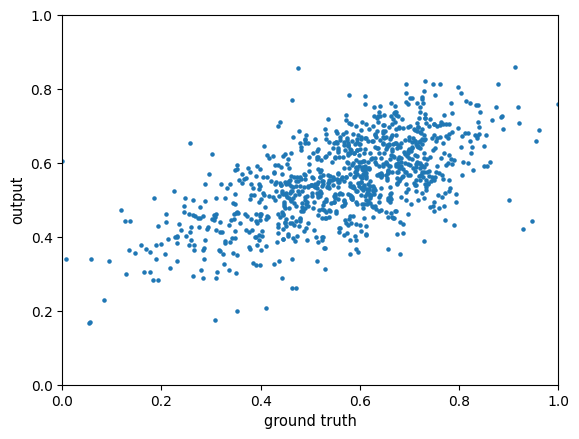

corr= 0.6236501335566454
MAE= 0.10013867768906722 ± 0.07763195504280451
相関係数: 0.623650133556646
p値: 1.5282540498040024e-108


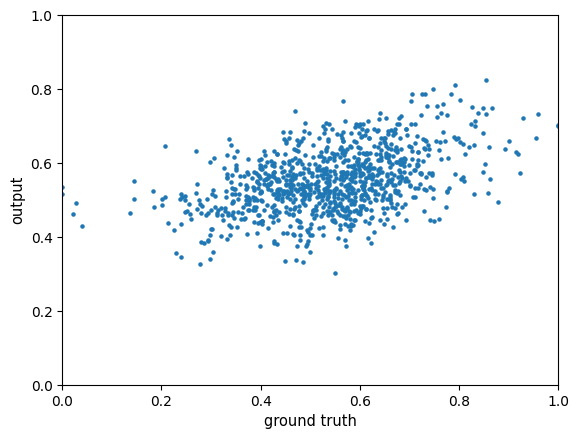

corr= 0.448714355305495
MAE= 0.10405495030692077 ± 0.07889547541223976
相関係数: 0.44871435530549514
p値: 1.4895786097758394e-50


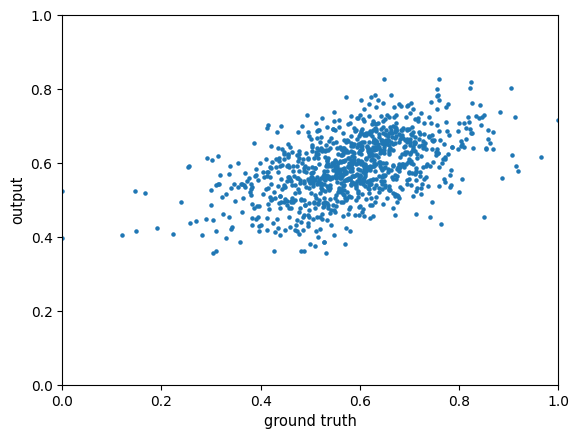

corr= 0.5092795906284655
MAE= 0.08504015865596791 ± 0.07075479543679453
相関係数: 0.5092795906284654
p値: 6.647044320499306e-67


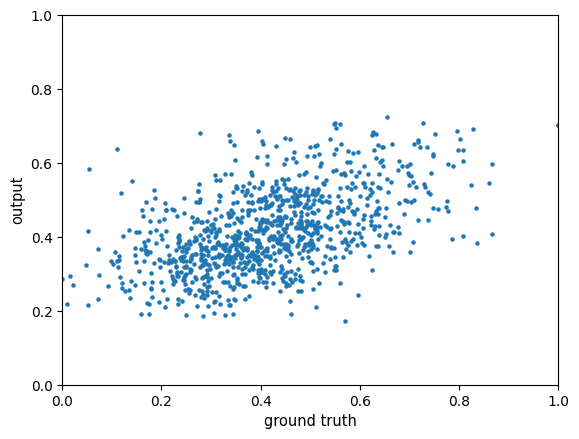

corr= 0.5193132052885641
MAE= 0.10672083304012037 ± 0.08511353247638241
相関係数: 0.5193132052885637
p値: 6.057543986886832e-70


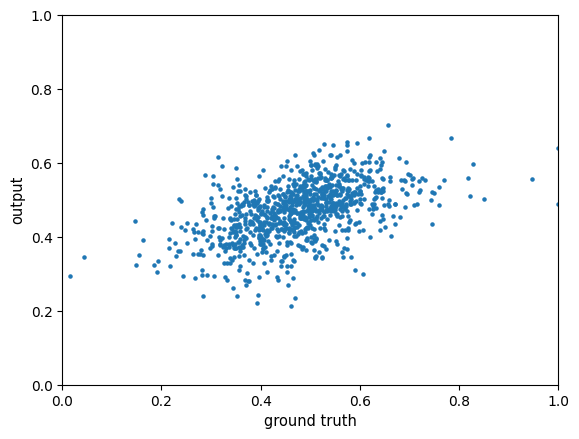

corr= 0.5091112362988904
MAE= 0.0753803814122367 ± 0.06417311184041713
相関係数: 0.5091112362988902
p値: 7.460735972452142e-67


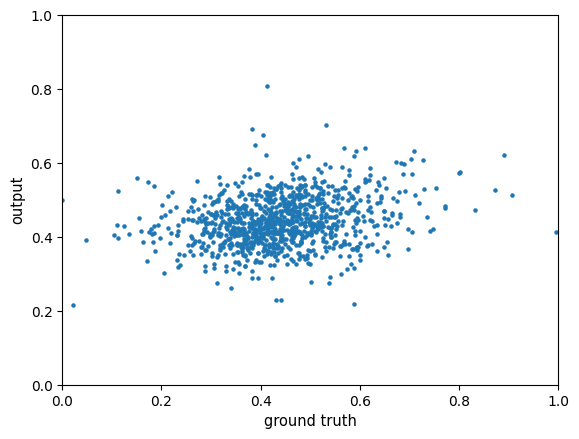

corr= 0.2371586281751918
MAE= 0.0937917450110331 ± 0.07952022228572506
相関係数: 0.23715862817519182
p値: 3.262268228008779e-14


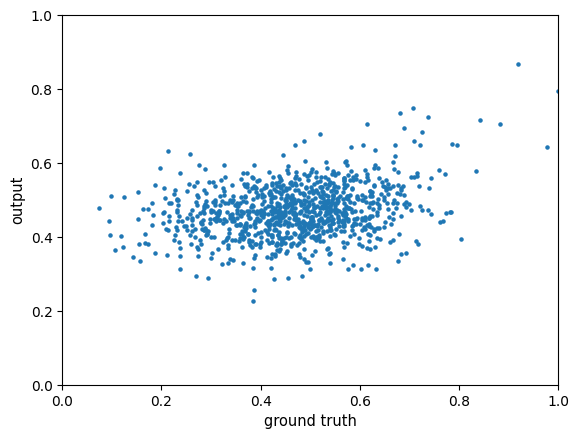

corr= 0.2863243451209285
MAE= 0.10520063996890672 ± 0.08093645780287663
相関係数: 0.2863243451209286
p値: 2.883170091504386e-20


In [25]:
mae_df = abs(out_df-score_df)
save_path = '/home/taki/bento_conditional/log/BEST_conditional_0_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014'
for i in range(len(col)):
    fig = plt.figure()
    plt.scatter(score_df[col[i]],
                out_df[col[i]],
                label=col[i],s=5)
                
    #plt.title("corr_score to output")
    plt.xlabel("ground truth",fontsize=10.5,fontname="Times New Roman")
    plt.ylabel("output",fontsize=10.5,fontname="Times New Roman")
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.legend()
    plt.savefig(save_path+f"/corr_{col[i]}.svg")
    plt.show()

    #plt.clf() # 図全体をクリア
    #plt.cla() # 軸をクリア
    #plt.close('all') # closes all the figure windows
    print("corr=",np.corrcoef(score_df[col[i]],out_df[col[i]])[0,1])
    print("MAE=", mae_df[col[i]].mean(), "±", mae_df[col[i]].std())
    a, b = pearsonr(score_df[col[i]], out_df[col[i]]) # リストを整形し相関係数:aとp値:bの計算
    print("相関係数:", a)
    print("p値:", b)

In [117]:
len(score_df)

500

## レーダーチャート保存

In [120]:
cv_num=0
csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"


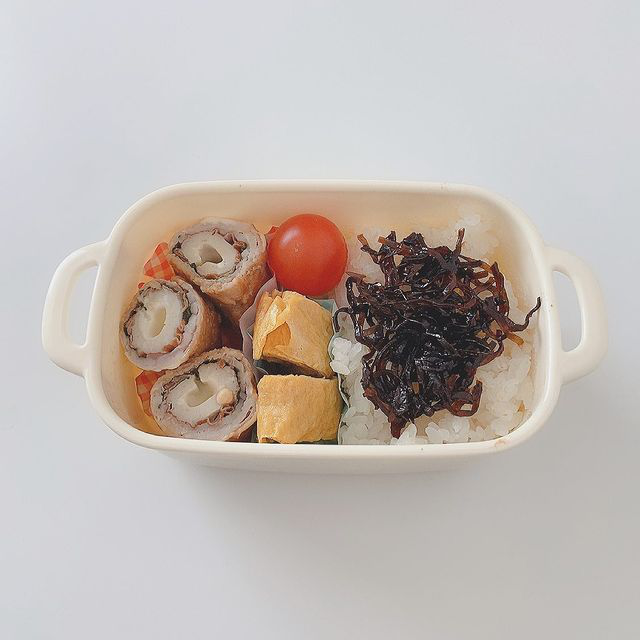

In [121]:
data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
df = pd.read_csv(dir+csv_dir)
img_path = data_dir + df["path"][0]

img = Image.open(img_path)
img

## 誤差が大きい上位１０枚表示

## 誤差が少ない上位１０マイ表示

In [26]:
small_list2 = mae_df["sum_mae"].nsmallest(2)
large_list2 = mae_df["sum_mae"].nlargest(2)

In [27]:
large_list2

485    2.077878
367    1.712622
Name: sum_mae, dtype: float64

In [19]:
mae_df

color   healthy  satisfaction  uniqueness  ease of eating  \
0    0.124944  0.174865      0.122345    0.020567        0.207591   
1    0.071166  0.013052      0.061764    0.035886        0.032729   
2    0.131948  0.197078      0.175859    0.058855        0.033433   
3    0.002113  0.024357      0.049903    0.021874        0.145092   
4    0.025378  0.006323      0.107523    0.117484        0.075905   
..        ...       ...           ...         ...             ...   
495  0.115347  0.123861      0.154976    0.017836        0.081159   
496  0.008282  0.001149      0.066343    0.162364        0.054716   
497  0.146078  0.092973      0.300912    0.059203        0.020429   
498  0.010186  0.046486      0.162704    0.136262        0.022087   
499  0.055254  0.081358      0.020008    0.064410        0.059260   

     appropriate amount  not collapse   img_mae   sum_mae  
0              0.149504      0.097597  0.128202  0.897413  
1              0.019104      0.076660  0.044337  0.310362  
2              0.012744      0.171313  0.111604  0.781231  
3              0.021843      0.115228  0.054344  0.380410  
4              0.006860      0.126118  0.066513  0.465591  
..                  ...           ...       ...       ...  
495            0.212264      0.056198  0.108806  0.761641  
496            0.047771      0.048697  0.055617  0.389322  
497            0.217681      0.152606  0.141412  0.989882  
498            0.118172      0.130721  0.089517  0.626618  
499            0.058823      0.031785  0.052985  0.370898  

[500 rows x 9 columns]

In [126]:
mae_df["img_mae"] = all_mae_list
mae_df = mae_df.reset_index(drop=True)
mae_df["sum_mae"] = sum_mae_list
mae_df = mae_df.reset_index(drop=True)
mae_df

color   healthy  satisfaction  uniqueness  ease of eating  \
0    0.124944  0.174865      0.122345    0.020567        0.207591   
1    0.071166  0.013052      0.061764    0.035886        0.032729   
2    0.131948  0.197078      0.175859    0.058855        0.033433   
3    0.002113  0.024357      0.049903    0.021874        0.145092   
4    0.025378  0.006323      0.107523    0.117484        0.075905   
..        ...       ...           ...         ...             ...   
495  0.115347  0.123861      0.154976    0.017836        0.081159   
496  0.008282  0.001149      0.066343    0.162364        0.054716   
497  0.146078  0.092973      0.300912    0.059203        0.020429   
498  0.010186  0.046486      0.162704    0.136262        0.022087   
499  0.055254  0.081358      0.020008    0.064410        0.059260   

     appropriate amount  not collapse   img_mae   sum_mae  
0              0.149504      0.097597  0.128202  0.897413  
1              0.019104      0.076660  0.044337  0.310362  
2              0.012744      0.171313  0.111604  0.781231  
3              0.021843      0.115228  0.054344  0.380410  
4              0.006860      0.126118  0.066513  0.465591  
..                  ...           ...       ...       ...  
495            0.212264      0.056198  0.108806  0.761641  
496            0.047771      0.048697  0.055617  0.389322  
497            0.217681      0.152606  0.141412  0.989882  
498            0.118172      0.130721  0.089517  0.626618  
499            0.058823      0.031785  0.052985  0.370898  

[500 rows x 9 columns]

In [20]:
small_list = mae_df["img_mae"].nsmallest(10)

small_list2 = mae_df["sum_mae"].nsmallest(10)
large_list = mae_df["img_mae"].nlargest(10)
large_list2 = mae_df["sum_mae"].nlargest(10)

In [21]:
score_df_list[3]

color   healthy  satisfaction  uniqueness  ease of eating  \
0   0.195570  0.212015      0.679119    0.392594        0.395552   
1   0.470651  0.322976      0.577261    0.455772        0.207195   
2   0.452384  0.691554      0.568596    0.321246        0.614406   
3   0.398225  0.408520      0.493461    0.363741        0.466947   
4   0.670225  0.727032      0.607532    0.325174        0.635874   
..       ...       ...           ...         ...             ...   
95  0.363711  0.355787      0.515556    0.421852        0.169964   
96  0.628817  0.743233      0.506016    0.450978        0.579951   
97  0.886580  0.894718      0.779159    0.481119        0.732035   
98  0.907388  0.941889      0.635946    0.661648        0.716740   
99  0.766378  0.576380      0.914502    0.395675        0.751703   

    appropriate amount  not collapse  
0             0.644581      0.394720  
1             0.379078      0.366039  
2             0.522066      0.390535  
3             0.496408      0.348272  
4             0.776084      0.440085  
..                 ...           ...  
95            0.525662      0.282783  
96            0.667277      0.403023  
97            0.712865      0.350705  
98            0.606651      0.469094  
99            0.697380      0.418493  

[100 rows x 7 columns]

In [136]:
for i in range(len(out_df_list)):
    #out_df_list[i] = out_df_list[i].drop("Unnamed: 0",axis=1)
    score_df_list[i] = score_df_list[i].drop("Unnamed: 0",axis=1)

score_df_list[3]

0         1         2         3         4         5         6
0   0.195570  0.212015  0.679119  0.392594  0.395552  0.644581  0.394720
1   0.470651  0.322976  0.577261  0.455772  0.207195  0.379078  0.366039
2   0.452384  0.691554  0.568596  0.321246  0.614406  0.522066  0.390535
3   0.398225  0.408520  0.493461  0.363741  0.466947  0.496408  0.348272
4   0.670225  0.727032  0.607532  0.325174  0.635874  0.776084  0.440085
..       ...       ...       ...       ...       ...       ...       ...
95  0.363711  0.355787  0.515556  0.421852  0.169964  0.525662  0.282783
96  0.628817  0.743233  0.506016  0.450978  0.579951  0.667277  0.403023
97  0.886580  0.894718  0.779159  0.481119  0.732035  0.712865  0.350705
98  0.907388  0.941889  0.635946  0.661648  0.716740  0.606651  0.469094
99  0.766378  0.576380  0.914502  0.395675  0.751703  0.697380  0.418493

[100 rows x 7 columns]

tomoko (63).jpg


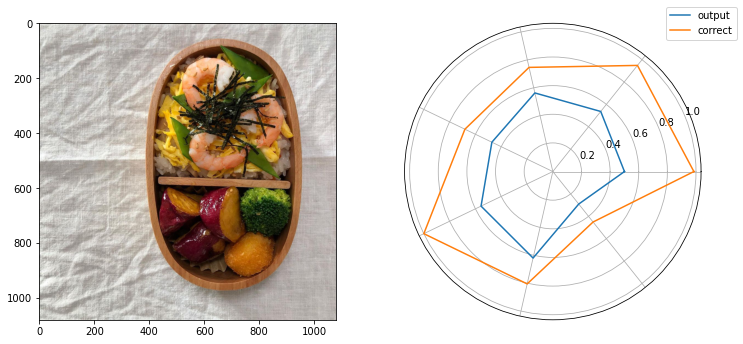

nagae_bento (130).jpg


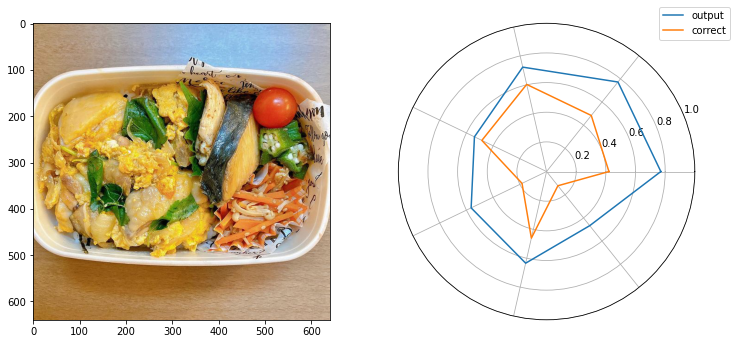

In [29]:
col = ["","","","","","",""]
for idx in large_list2.index:

    if idx < 100:
        cv_num = 0
        i = idx-cv_num*100
    elif 100 <  idx and idx < 200:
        cv_num = 1
        i = idx-cv_num*100
    elif 200 <  idx and idx < 300:
        cv_num = 2
        i = idx-cv_num*100
    elif 300 <  idx and idx < 400:
        cv_num = 3
        i = idx-cv_num*100
    elif 400 <  idx and idx < 500:
        cv_num = 4
        i = idx-cv_num*100

    csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/test_svg'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/high_mae"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + df["path"][i]
    img = Image.open(img_path)
    img.save(f"high_cv_num={cv_num}loc[{i}]"+df["path"][i])

    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(score_df_list[cv_num].loc[i], score_df_list[cv_num].loc[i][0])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)

    #img_path = data_dir +  img_name[index_list[i]]
    #ax0.imshow(mpimg.imread(img_path))

    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)
    

    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col,fontname="Times New Roman")
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    #plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_{i}.png"
    img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{large_list2[idx]}.svg"

    print(df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows

In [139]:
large_list2

485    2.077878
367    1.712622
282    1.519767
85     1.451414
176    1.425473
319    1.342809
40     1.289389
444    1.252403
196    1.232731
195    1.223306
Name: sum_mae, dtype: float64

In [140]:
small_list2

49     0.191295
484    0.198845
89     0.201499
480    0.203981
221    0.204433
161    0.212151
481    0.239923
187    0.256094
120    0.259258
206    0.281075
Name: sum_mae, dtype: float64

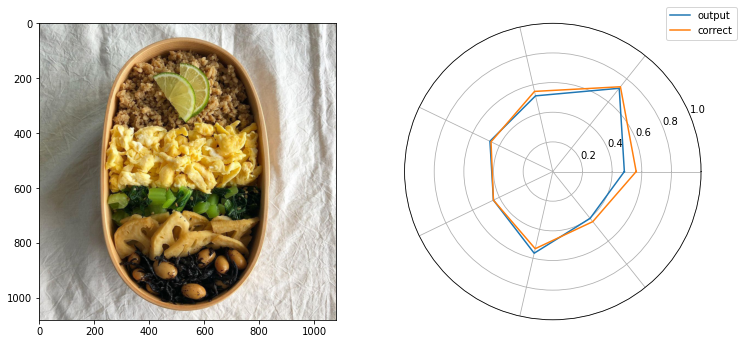

uco (17).jpg


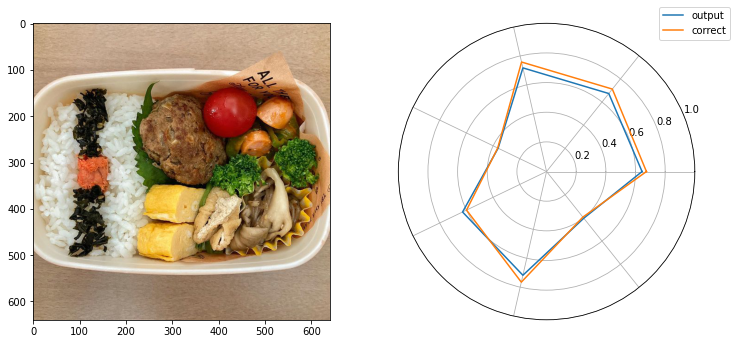

nagae_bento (150).jpg


In [30]:
col = ["","","","","","",""]
for idx in small_list2.index:

    if idx < 100:
        cv_num = 0
        i = idx-cv_num*100
    elif 100 <  idx and idx < 200:
        cv_num = 1
        i = idx-cv_num*100
    elif 200 <  idx and idx < 300:
        cv_num = 2
        i = idx-cv_num*100
    elif 300 <  idx and idx < 400:
        cv_num = 3
        i = idx-cv_num*100
    elif 400 <  idx and idx < 500:
        cv_num = 4
        i = idx-cv_num*100

    csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/test_svg'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/low_mae"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + df["path"][i]
    img = Image.open(img_path)
    img.save(f"low_cv_num={cv_num}loc[{i}]"+df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(score_df_list[cv_num].loc[i], score_df_list[cv_num].loc[i][0])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col,fontname="Times New Roman")
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows

In [ ]:
small_list2.index

Int64Index([49, 484, 89, 480, 221, 161, 481, 187, 120, 206], dtype='int64')

In [ ]:
small_list2[49]

0.19129538000000013

In [ ]:
mae_df.iloc[485]

color                 0.484758
healthy               0.411419
satisfaction          0.183167
uniqueness            0.209056
ease of eating        0.443656
appropriate amount    0.185322
not collapse          0.160499
img_mae               0.296840
sum_mae               2.077878
Name: 485, dtype: float64

In [ ]:
out_df.iloc[485]

color                 0.500412
healthy               0.536718
satisfaction          0.563035
uniqueness            0.472401
ease of eating        0.556344
appropriate amount    0.619650
not collapse          0.290354
Name: 485, dtype: float64

In [ ]:
score_df.iloc[485]

color                 0.985170
healthy               0.948136
satisfaction          0.746202
uniqueness            0.681458
ease of eating        1.000000
appropriate amount    0.804972
not collapse          0.450853
Name: 485, dtype: float64

## 適量のスコア確認

In [9]:
all_df = pd.read_csv("./score_ml_promax_7.csv")
all_df

path   factor1   factor2   factor3   factor4   factor5  \
0    11n24y (10).jpg  0.626011  0.512187  0.667759  0.278341  0.679017   
1    11n24y (15).jpg  0.418966  0.577724  0.472596  0.154524  0.519459   
2    11n24y (20).jpg  0.544230  0.482227  0.734638  0.268911  0.674837   
3    11n24y (22).jpg  0.434133  0.684328  0.324193  0.268570  0.467308   
4    11n24y (24).jpg  0.478149  0.539188  0.227575  0.338072  0.437760   
..               ...       ...       ...       ...       ...       ...   
995  yumben (57).jpg  0.649259  0.649115  0.638141  0.379576  0.643529   
996  yumben (58).jpg  0.405739  0.364467  0.716503  0.342739  0.554483   
997  yumben (59).jpg  0.453467  0.285186  0.835852  0.285848  0.391417   
998  yumben (60).jpg  0.717414  0.582687  0.548351  0.454048  0.435609   
999   yumben (9).jpg  0.560285  0.621916  0.514575  0.475604  0.588288   

      factor6   factor7  
0    0.644536  0.385473  
1    0.653625  0.461815  
2    0.755683  0.368004  
3    0.839506  0.470191  
4    0.667763  0.355663  
..        ...       ...  
995  0.731639  0.363457  
996  0.523175  0.407680  
997  0.458061  0.253789  
998  0.778868  0.589075  
999  0.713600  0.247430  

[1000 rows x 8 columns]

In [11]:
all_score_df = all_df.drop("path",axis=1)
all_score_df

factor1   factor2   factor3   factor4   factor5   factor6   factor7
0    0.626011  0.512187  0.667759  0.278341  0.679017  0.644536  0.385473
1    0.418966  0.577724  0.472596  0.154524  0.519459  0.653625  0.461815
2    0.544230  0.482227  0.734638  0.268911  0.674837  0.755683  0.368004
3    0.434133  0.684328  0.324193  0.268570  0.467308  0.839506  0.470191
4    0.478149  0.539188  0.227575  0.338072  0.437760  0.667763  0.355663
..        ...       ...       ...       ...       ...       ...       ...
995  0.649259  0.649115  0.638141  0.379576  0.643529  0.731639  0.363457
996  0.405739  0.364467  0.716503  0.342739  0.554483  0.523175  0.407680
997  0.453467  0.285186  0.835852  0.285848  0.391417  0.458061  0.253789
998  0.717414  0.582687  0.548351  0.454048  0.435609  0.778868  0.589075
999  0.560285  0.621916  0.514575  0.475604  0.588288  0.713600  0.247430

[1000 rows x 7 columns]

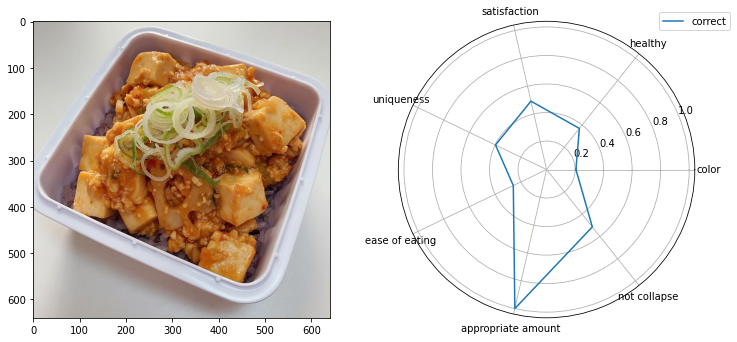

11n24y (28).jpg


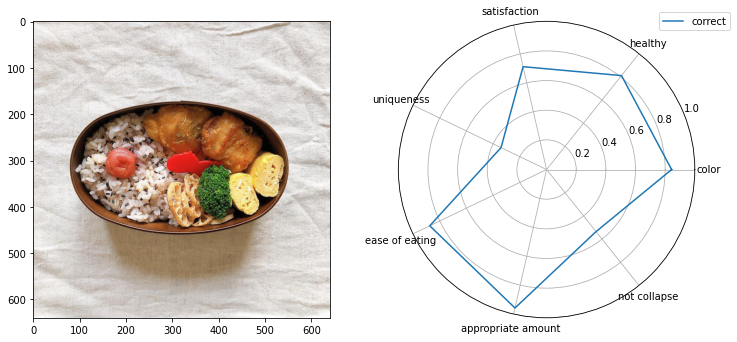

11n24y (28).jpg


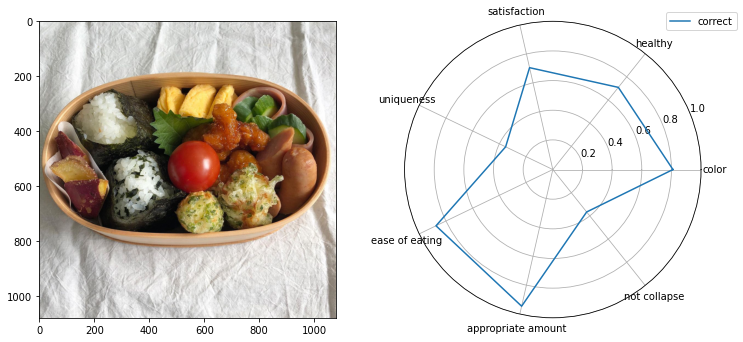

11n24y (28).jpg


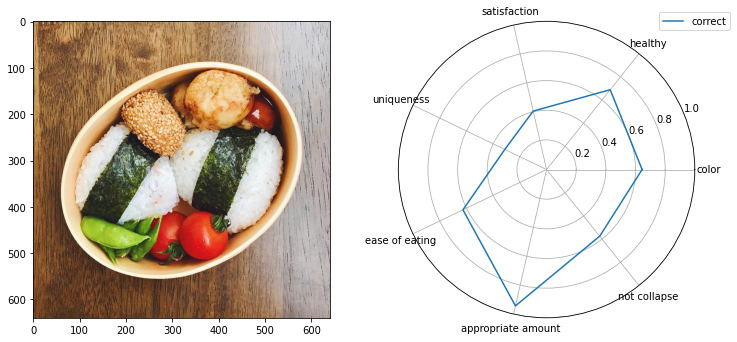

11n24y (28).jpg


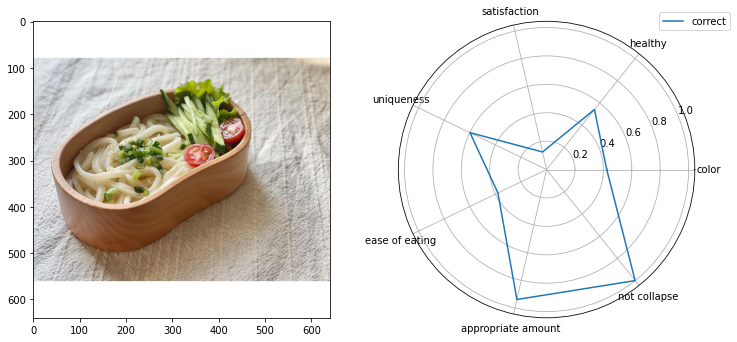

11n24y (28).jpg


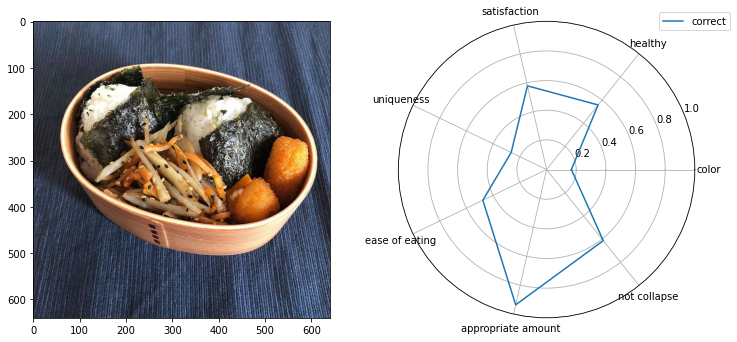

11n24y (28).jpg


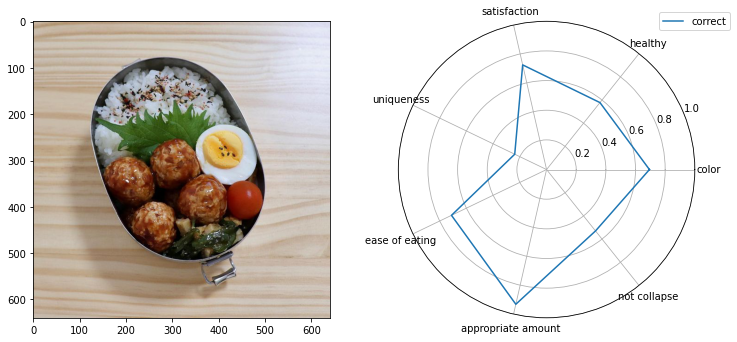

11n24y (28).jpg


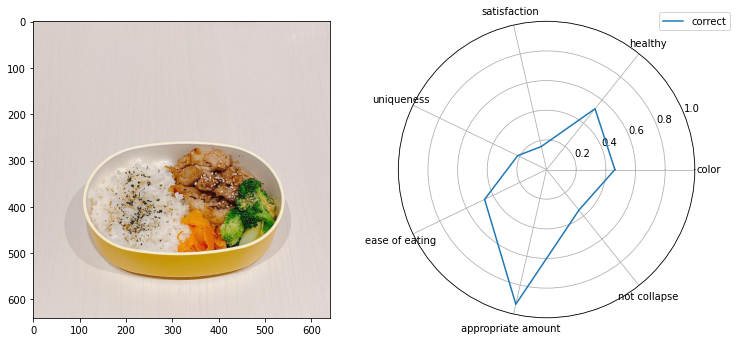

11n24y (28).jpg


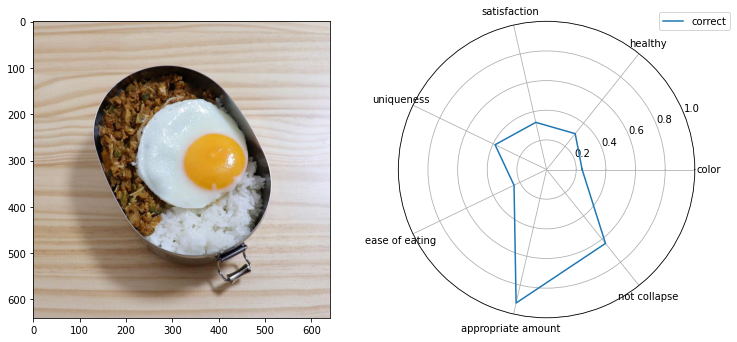

11n24y (28).jpg


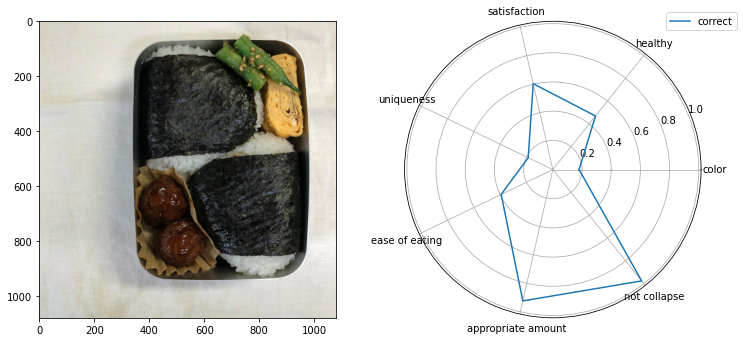

11n24y (28).jpg


In [33]:
from ipywidgets import interact

ap_am_large_list = all_score_df["factor6"].nlargest(10)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]


for idx in ap_am_large_list.index:

    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows

In [32]:
from ipywidgets import interact


ap_am_large_list = all_score_df["factor6"].nlargest(10)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

@interact(k=(0,len(ap_am_large_list.index)-1))

def plot_factor6(k):
    idx = ap_am_large_list.index[k]
    print("適量")
    print(idx)
    
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=4, description='k', max=9), Output()), _dom_classes=('widget-interact',)…

In [22]:
ap_am_large_list.index[0]

760

In [46]:
from ipywidgets import interact


not_collapse_am_large_list = all_score_df["factor7"].nlargest(500)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

@interact(k=(0,len(not_collapse_am_large_list.index)-1))

def plot_factor7(k):
    i=7-1
    idx = not_collapse_am_large_list.index[k]
    print("まとまり感")
    print(idx)
    
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])
    print("スコア:",all_score_df.loc[idx][i])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=249, description='k', max=499), Output()), _dom_classes=('widget-interac…

In [36]:
from ipywidgets import interact


not_collapse_am_large_list = all_score_df["factor1"].nlargest(30)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

@interact(k=(0,len(not_collapse_am_large_list.index)-1))

def plot_factor1(k):
    idx = not_collapse_am_large_list.index[k]
    print("彩り")
    print(idx)
    
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=4, description='k', max=9), Output()), _dom_classes=('widget-interact',)…

In [37]:
from ipywidgets import interact


not_collapse_am_large_list = all_score_df["factor2"].nlargest(30)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

@interact(k=(0,len(not_collapse_am_large_list.index)-1))

def plot_factor1(k):
    idx = not_collapse_am_large_list.index[k]
    print("健康的")
    print(idx)
    
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=14, description='k', max=29), Output()), _dom_classes=('widget-interact'…

In [40]:
from ipywidgets import interact


not_collapse_am_large_list = all_score_df["factor3"].nlargest(30)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

@interact(k=(0,len(not_collapse_am_large_list.index)-1))

def plot_factor3(k):
    i=3-1
    idx = not_collapse_am_large_list.index[k]
    print("満足感")
    print("index:",idx)

    
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])
    print("満足感スコア:",all_score_df.loc[idx][i])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=14, description='k', max=29), Output()), _dom_classes=('widget-interact'…

In [42]:
from ipywidgets import interact


not_collapse_am_large_list = all_score_df["factor4"].nlargest(30)
col = ["color","healthy","satisfaction","uniqueness","ease of eating","appropriate amount","not collapse"]

@interact(k=(0,len(not_collapse_am_large_list.index)-1))

def plot_factor4(k):
    i=4-1
    idx = not_collapse_am_large_list.index[k]
    print("ユニークさ")
    print("index:",idx)

    
    #csv_dir = f"/seed{1}/closs_valid{cv_num}/closs_valid{cv_num}testdata_index.csv"
    save_path = f'/home/taki/B4_report/log/bento_train_log/closs_valid/best/optimAdam_batch32_w,h640_lr0.0001_wDecay0.01/seed{1}/score_chart'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_path = save_path + "/factor6"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    data_dir = "/dataset/dataset/taki/data/bento/bento_dataset1000/"
    #df = pd.read_csv(dir+csv_dir)
    img_path = data_dir + all_df["path"][idx]
    img = Image.open(img_path)
    #img.save(f"low_cv_num={cv_num}loc[{i}]"+all_df["path"][i])


    # 多角形を閉じるためにデータの最後に最初の値を追加する。
    #output_values = np.append(out_df_list[cv_num].loc[i], out_df_list[cv_num].loc[i][0])
    score_values  = np.append(all_score_df.loc[idx], all_score_df.loc[idx][0])
    print("スコア:",all_score_df.loc[idx][i])

    # プロットする角度を生成する。
    angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

    plt.rcParams['font.family']='Times New Roman'

    fig = plt.figure(figsize=(12, 12))

    # libのmatplotのファイルのデフォルトフォントを変えた
    #plt.rcParams['font.family'] = 'IPAexGothic'
    #print(plt.rcParams["font.family"])
    #plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2, polar=True)


    ax0.imshow(img)
    #ax0.set_title(img_path[index_list[i]], pad=20)


    # 極座標でaxを作成。
    # レーダーチャートの線を引く
    #ax1.plot(angles, output_values, label="output")
    ax1.plot(angles, score_values, label="correct")

    # 項目ラベルの表示
    ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col)
    ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

    ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0)

    #ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
    plt.show()

    #img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{small_list2[idx]}.svg"

    print(all_df["path"][i])

    #plt.savefig(img_path)#, transparent=True)
    #plt.show()

    plt.clf() # 図全体をクリア
    plt.cla() # 軸をクリア
    plt.close('all') # closes all the figure windows



interactive(children=(IntSlider(value=14, description='k', max=29), Output()), _dom_classes=('widget-interact'…